In [1]:
import os,sys
import matplotlib.pyplot as plt
sys.path.append( os.environ['OACIS_ROOT'] )
import oacis

In [2]:
sim = oacis.Simulator.find_by_name("NS_model")
host = oacis.Host.find_by_name("localhost")

In [3]:
import numpy as np

rho_values = np.linspace( 0.05, 0.5, 10)
base_param = { "l": 200, "v": 5, "p": 0.1, "t_init": 100, "t_measure": 1000 }

created_ps_list = []
for rho in rho_values:
    param = base_param.copy()
    param['rho'] = rho
    ps = sim.find_or_create_parameter_set( param )
    runs = ps.find_or_create_runs_upto(1, submitted_to=host)
    created_ps_list.append(ps)

len(created_ps_list)

10

In [4]:
# an idiom to wait until all the parameter_sets finish
w = oacis.OacisWatcher()
w.watch_all_ps( created_ps_list, lambda pss: None)
w.loop()

2020-01-14 06:23:22,813 - oacis.oacis_watcher - INFO - start polling
2020-01-14 06:23:22,823 - oacis.oacis_watcher - INFO - calling callback for ('5e1d59038952347583b1d33c', '5e1d59038952347583b1d33e', '5e1d59038952347583b1d340', '5e1d59038952347583b1d342', '5e1d59038952347583b1d344', '5e1d59038952347583b1d346', '5e1d59048952347583b1d348', '5e1d59048952347583b1d34a', '5e1d59048952347583b1d34c', '5e1d59048952347583b1d34e')
2020-01-14 06:23:22,852 - oacis.oacis_watcher - INFO - stop polling. (interrupted=False)


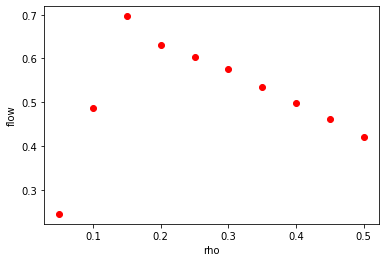

In [5]:


parameter_sets = sorted( created_ps_list, key= lambda ps: ps.v()['rho'] )
x = []
y = []
for ps in parameter_sets:
    x.append( ps.v()["rho"] )
    y.append( ps.average_result("flow")[0] )
    
plt.xlabel("rho")
plt.ylabel("flow")
plt.plot(x,y, 'ro')

## Searching an optimum $\rho$

It seems that there is an optimal $\rho$ to maximize the traffic flow. Let us search the optimum value iteratively.
Algorithm for searching:

1. take the PS having the largest "flow".
1. create two ParameterSets at the centers between its neighboring PSs.
1. go back to 1 until we have enough resolution.

In [6]:
   
def find_nearest_neighbors( ps, input_key ):
    ps_list = list( ps.parameter_sets_with_different( input_key ) )
    idx = ps_list.index( ps )
    left_ps = ps_list[idx-1] if idx > 0 else None
    right_ps = ps_list[idx+1] if idx+1 < len(ps_list) else None
    return (left_ps, right_ps)

def find_optimum_ps( sim, input_key, output_key, base_param):
    query = { "v.%s"%k:v for k,v in base_param.items() if k != input_key }
    parameter_sets = sim.parameter_sets().where( query ).to_a()
    oacis.OacisWatcher.await_all_ps( parameter_sets )
    sorted_by_output = sorted( parameter_sets, key=lambda ps: ps.average_result(output_key)[0] )
    best_ps = sorted_by_output[-1]
    return best_ps

def create_a_new_ps_in_between( ps1, ps2, input_key ):
    new_param = ps1.v()
    new_param[input_key] = (ps1.v()[input_key] + ps2.v()[input_key]) / 2.0
    new_ps = sim.find_or_create_parameter_set( new_param )
    new_runs = new_ps.find_or_create_runs_upto(1, submitted_to=oacis.Host.find_by_name("localhost") )
    return new_ps

def create_initial_pss(sim, input_key, base_param, domain=(0.05,0.95)):
    param1 = base_param.copy()
    param1[input_key] = domain[0]
    ps1 = sim.find_or_create_parameter_set( param1 )
    ps1.find_or_create_runs_upto(1, submitted_to=oacis.Host.find_by_name("localhost") )
    param2 = base_param.copy()
    param2[input_key] = domain[1]
    ps2 = sim.find_or_create_parameter_set( param2 )
    ps2.find_or_create_runs_upto(1, submitted_to=oacis.Host.find_by_name("localhost") )
    return (ps1,ps2)

def search_for_optimum( sim, input_key, output_key, base_param, resolution):
    create_initial_pss(sim, input_key, base_param)
    best_ps = find_optimum_ps( sim, input_key, output_key, base_param )
    left_ps, right_ps = find_nearest_neighbors( best_ps, input_key )
    new_ps_list = []
    if (left_ps is not None) and abs(left_ps.v()[input_key]-best_ps.v()[input_key]) > resolution:
        new_ps1 = create_a_new_ps_in_between( left_ps, best_ps, input_key )
        new_ps_list.append(new_ps1)
    if (right_ps is not None) and abs(right_ps.v()[input_key]-best_ps.v()[input_key]) > resolution:
        new_ps2 = create_a_new_ps_in_between( right_ps, best_ps, input_key )
        new_ps_list.append(new_ps2)
    if len(new_ps_list) > 0:
        return search_for_optimum( sim, input_key, output_key, base_param, resolution)
    else:
        return best_ps

sim = oacis.Simulator.find_by_name("NS_model")
base_param = { "l": 200, "v": 5, "p": 0.1, "t_init": 100, "t_measure": 1000 }
# best_ps = find_optimum_ps( sim, 'rho', 'flow', base_param)
# print( best_ps.v() )
# left, right = find_nearest_neighbors( best_ps, 'rho' )
# print( left.v(), right.v() )
# create_a_new_ps_in_between( left, best_ps, 'rho' )

w = oacis.OacisWatcher()
best_ps = None
def f():
    global best_ps
    best_ps = search_for_optimum( sim, 'rho', 'flow', base_param, 0.005)
w.do_async(f)
w.loop()
best_ps.v()

2020-01-14 06:23:23,202 - oacis.oacis_watcher - INFO - start polling
2020-01-14 06:23:23,220 - oacis.oacis_watcher - INFO - calling callback for ('5e1d59038952347583b1d33c', '5e1d59038952347583b1d33e', '5e1d59038952347583b1d340', '5e1d59038952347583b1d342', '5e1d59038952347583b1d344', '5e1d59038952347583b1d346', '5e1d59048952347583b1d348', '5e1d59048952347583b1d34a', '5e1d59048952347583b1d34c', '5e1d59048952347583b1d34e', '5e1d59788952347583b1d350', '5e1d598c8952347583b1d352', '5e1d598c8952347583b1d354', '5e1d59a18952347583b1d356', '5e1d59a18952347583b1d358', '5e1d59b08952347583b1d35a', '5e1d59b08952347583b1d35c', '5e1d59ba8952347583b1d35e', '5e1d59ba8952347583b1d360')
2020-01-14 06:23:23,365 - oacis.oacis_watcher - INFO - stop polling. (interrupted=False)


{'l': 200,
 'v': 5,
 'rho': 0.15000000000000002,
 'p': 0.1,
 't_init': 100,
 't_measure': 1000}

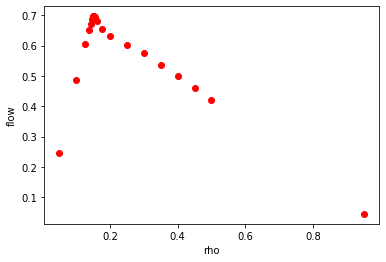

In [7]:
def plot_rho_flow_diagram( best_ps ):
    import matplotlib.pyplot as plt
    parameter_sets = best_ps.parameter_sets_with_different( 'rho' )
    x = []
    y = []
    for ps in parameter_sets:
        x.append( ps.v()["rho"] )
        y.append( ps.average_result("flow")[0] )
    plt.xlabel("rho")
    plt.ylabel("flow")
    plt.plot(x,y, 'ro')
    
plot_rho_flow_diagram(best_ps)

In [8]:
from functools import partial
sim = oacis.Simulator.find_by_name("NS_model")
p_list = [0.1, 0.3, 0.5]
v_list = [3,4,5,6,7]
w = oacis.OacisWatcher()
best_ps_dict = {}

def best_rho(v, p):
    base_param = { "l": 200, "v": v, "p": p, "t_init": 100, "t_measure": 1000 }
    best_ps = search_for_optimum( sim, 'rho', 'flow', base_param, 0.005)
    best_ps_dict[(p,v)] = best_ps.v()['rho']

for p in p_list:
    for v in v_list:
        f = partial( best_rho, v, p )
        w.do_async(f)
w.loop()

best_ps_dict

2020-01-14 06:23:24,068 - oacis.oacis_watcher - INFO - start polling
2020-01-14 06:23:24,123 - oacis.oacis_watcher - INFO - calling callback for ('5e1d5a628952347583b1d362', '5e1d5a628952347583b1d364', '5e1d5a878952347583b1d39a', '5e1d5b0d8952347583b1d3b4', '5e1d5b0d8952347583b1d3b6', '5e1d5b6c8952347583b1d3e6', '5e1d5b6d8952347583b1d3e8', '5e1d5bee8952347583b1d418', '5e1d5bee8952347583b1d41a', '5e1d5c528952347583b1d44e', '5e1d5c528952347583b1d450', '5e1d5c988952347583b1d484', '5e1d5c988952347583b1d486', '5e1d5cf18952347583b1d4bc', '5e1d5cf18952347583b1d4be', '5e1d5d378952347583b1d4f4', '5e1d5d378952347583b1d4f6')
2020-01-14 06:23:24,214 - oacis.oacis_watcher - INFO - calling callback for ('5e1d5a628952347583b1d366', '5e1d5a628952347583b1d368', '5e1d5a878952347583b1d39c', '5e1d5b1d8952347583b1d3ba', '5e1d5b1d8952347583b1d3bc', '5e1d5b818952347583b1d3ea', '5e1d5b818952347583b1d3ec', '5e1d5bf48952347583b1d420', '5e1d5bf48952347583b1d422', '5e1d5c5d8952347583b1d456', '5e1d5c5d8952347583b1

{(0.1, 3): 0.24335937500000002,
 (0.1, 4): 0.190625,
 (0.1, 5): 0.15000000000000002,
 (0.1, 6): 0.13789062500000002,
 (0.1, 7): 0.12031250000000002,
 (0.3, 3): 0.22578125,
 (0.3, 4): 0.1484375,
 (0.3, 5): 0.12734375000000003,
 (0.3, 6): 0.10625000000000001,
 (0.3, 7): 0.0921875,
 (0.5, 3): 0.1484375,
 (0.5, 4): 0.11328125000000001,
 (0.5, 5): 0.0921875,
 (0.5, 6): 0.081640625,
 (0.5, 7): 0.074609375}

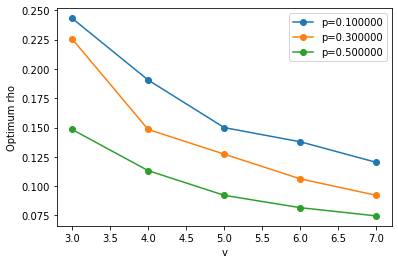

In [9]:
# After searching we plot the optimal rho for each v and p.
plt.figure()
plt.xlabel('v')
plt.ylabel('Optimum rho')

for p in p_list:
    opt_rho_list = []
    for v in v_list:
        opt_rho = best_ps_dict[ (p,v) ]
        opt_rho_list.append( opt_rho )
    plt.plot( v_list, opt_rho_list, 'o-', label="p=%f"%p )
plt.legend(loc='best')
plt.show()